# Minimum volume ellipsoid (outlier detection)



In [1]:
%matplotlib inline

# Future 
from __future__ import print_function

# Numpy imports 
import numpy as np
import numpy.random as random

import scipy as sp
import scipy.linalg as la


# Import matplotlib.pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# My imports 
from ellipsoidal_outlier_detector import EllipsoidSolver



EPS = sp.finfo(float).eps



# 3D scatter plot example 

Print some rough problem size estimates:
d = 3
M = 500
Na= 9

d**2 = 9
Na**2 = 81


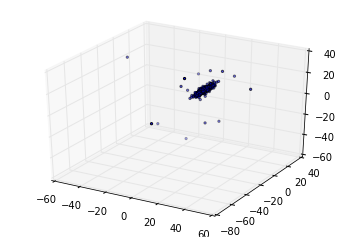

In [2]:
# Generate random samples for testing the algorithm 

Ndim = 3
Na = Ndim
Nsamples = 500


mean = np.array(Ndim * [5.0,])
cov = sp.eye(Ndim) + 5.0

samples = random.multivariate_normal(mean, cov, Nsamples)
samples[:20] = random.laplace(5, scale =10.0001, size=(20, mean.size))
#plt.plot(samples[:, 0], samples[:, 1], 'or', markersize=4)
#plt.axis('equal')


# Make a 3D figure
fig = plt.figure(0)
fig.clear()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(samples[:,0], 
           samples[:,1],
           samples[:,2], marker='.')

## Problem size estimates
print("Print some rough problem size estimates:")

d = Ndim
M = Nsamples

Na = int(d * (d+1) / 2.0 + d)

print("d = {0}\nM = {1}\nNa= {2}".format(d, M, Na), end='\n\n')
print("d**2 = {0}".format(d**2))
print("Na**2 = {0}".format(Na**2))

In [6]:
def get_partition(xarray, avec0=None, EllipsoidSolver=EllipsoidSolver):
    """
    Compute the outliers and split them off
  
    Compute outliers in sequance for all points.
    
    in
    --
    xarray   - array shaped (M, d) for M samples of d-dimensional vecs
    avec0    - Optional initial guess for the ellipse state vector 


    out
    ---
    xin      - samples inside the minimum ellipse 
    xout     - samples on the boundary of the ellipse
    vol      - constand proportional to the volume (1.0 / det(A))
    A        - Array defining the ellipse 
    b        - Vector defining the offset of ellipse 
    avec     - state vector for minimum volume ellipse 
    
    
    * Note *
    Use the kwarg avec0 to initialize the ellipse optimization.  


    """
    
    # Define a solver for these filter vectors
    esolver = EllipsoidSolver(xarray, a0=avec0)
    
    # Get the min. vol. ellipse containing all points 
    avec, vol, A, b = esolver.get_optimal_ellipse()
    
    # Plit the xarray into interior and boundary points
    xin, xout = esolver.get_xinxout(A, b)
    
    return xin, xout, vol, A, b, avec
    

    
    

In [8]:
out = get_partition(samples)

print(out)




     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -4.7988e+02  5e+02  1e+00  1e+00
 1:  1.2695e+01  4.1141e+00  9e+00  1e-02  7e-02
 2:  1.2301e+01  1.1810e+01  6e-01  1e-02  5e-02
 3:  1.1617e+01  1.1598e+01  2e-01  2e-01  3e-02
 4:  1.1638e+01  1.1613e+01  2e-01  2e-01  2e-02
 5:  1.1708e+01  1.1677e+01  7e-02  3e-02  6e-03
 6:  1.1734e+01  1.1725e+01  2e-02  8e-03  2e-03
 7:  1.1742e+01  1.1741e+01  2e-03  6e-04  2e-04
 8:  1.1742e+01  1.1742e+01  2e-04  5e-05  1e-05
 9:  1.1742e+01  1.1742e+01  5e-05  1e-05  4e-06
10:  1.1742e+01  1.1742e+01  8e-06  2e-06  8e-07
11:  1.1742e+01  1.1742e+01  5e-07  2e-07  5e-08
12:  1.1742e+01  1.1742e+01  8e-09  3e-09  8e-10
Optimal solution found.
(array([[ -7.75896683,  -4.01775089,   9.09431785],
       [  7.09364637,   2.79560289,   8.25692455],
       [ 15.14441268,  28.16831564,  11.43780999],
       ..., 
       [  5.5172301 ,   7.42594575,   7.00681661],
       [  4.67126917,   3.9066593 ,   3.99883356],
       [  5.75939985, 

In [ ]:

def get_total_partition(xarray, EllipsoidSolver=EllipsoidSolver):
    """
    Compute outliers in sequance for all points.
    
    in
    --
    xarray    - array shaped (M, d) for M samples of d-dimensional vecs

    out
    ---
    xin_list    - list of partitions 
    xout_list   - 
    volumes     - array of ellipsoid volumes
    A_arrs      - A_arrs define the covarience of ellipse
    b_vecs      - b_vecs define the center of the ellipse
    Fe          - The interface to CVXOPT
    
    """
    
    # Define an interface to cvxopt
    Fe = FEllipsoid(xarray)
    Mstart = Fe.M
    
    
    # Initialize output
    xout_list = []
    xin_list = []
    pstars = sp.zeros((Fe.M,))
    A_arrs = sp.zeros((Fe.M, Fe.ndim, Fe.ndim))
    b_vecs = sp.zeros((Fe.M, Fe.ndim))
    
    
    # Loop until the set of points has been partitioned
    for i in range(Mstart):
        
        # Get the next ellipse
        astar, pstar, A, b = get_optimal_ellipse(Fe)
    
        # Separate points
        xin, xout = xinxout(Fe, A, b)
        
        # Make a new ellipsoid solver
        Fe = FEllipsoid(xin, a0=astar)
        
        # Store data for output
        xout_list.append(xout)
        xin_list.append(xin)
        pstars[i] = pstar
        A_arrs[i, :, :] = A
        b_vecs[i, :] = b
        
        if xin.shape[0] < Mstart / 2.0:
            ibound = i + 1            
            break
    
        
    # Prepare output
    pstars = pstars[:ibound]
    A_arrs = A_arrs[:ibound, :, :]
    b_vecs = b_vecs[:ibound, :]
    
    return xin_list, xout_list, pstars, A_arrs, b_vecs



## Solve for the minimum volume ellipsoid containing all the points


# Make a plot showing min. vol ellipsoid

# Determine candidats for removal

In [ ]:
def plot_xinxout(xin, xout, Ainv, b):
    "Make a 3D scatter plot with some data"
    
    
    # Make a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(xin[:,0], xin[:,1], xin[:,2], marker='.')
    ax.scatter(xout[:,0], xout[:,1], xout[:,2], marker='o', c='r')

    
    ## Get points on a sphere
    thetas = sp.linspace(100*EPS, (1.0-100*EPS) * sp.pi, 20)
    phis = sp.linspace(0.0, 2*sp.pi, 20)

    TT, PP = sp.meshgrid(thetas, phis, indexing='ij')

    xx = sp.cos(PP) * sp.sin(TT)
    yy = sp.sin(PP) * sp.sin(TT)
    zz = sp.cos(TT)


    Ainv_xx = Ainv[:,0, None, None] * (xx - b[None, None, 0])
    Ainv_yy = Ainv[:,1, None, None] * (yy - b[None, None, 1])
    Ainv_zz = Ainv[:,2, None, None] * (zz - b[None, None, 2])

    xyz_ellipse = Ainv_xx + Ainv_yy + Ainv_zz
    xe = xyz_ellipse[0]
    ye = xyz_ellipse[1]
    ze = xyz_ellipse[2]

    
    ax.plot_wireframe(xe, ye, ze, linewidth=0.1)
    
    
    return fig
    
    

In [ ]:
out = get_total_partition(samples)

In [ ]:
xins, xouts, ps, As, bs = out[:]

In [ ]:
plt.semilogy(ps)

In [ ]:
nout = [len(_xout) for _xout in xouts]
nin = [len(_xin) for _xin in xins]

In [ ]:
zip(nin, nout)

In [ ]:
for i in range(len(xins))[:20]: #[0, 1, 2, 3, 10, 20]:
    fig = plot_xinxout(xins[i], xouts[i], la.inv(As[i]), bs[i])